In [1]:
#supress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import sys
import os
_stderr = sys.stderr
null = open(os.devnull,'wb')


import os
work_dir = 'Processed_data'


import scanpy as sc
#set some figure parameters for nice display inside jupyternotebooks.
%matplotlib inline
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(5, 5), facecolor='white')

#make a directory for to store the processed scRNA-seq data.
if not os.path.exists(os.path.join(work_dir, 'scRNA')):
    os.makedirs(os.path.join(work_dir, 'scRNA'))
    

import sys
!{sys.executable} -m pip -q install palantir fa2

import warnings
warnings.filterwarnings("ignore")
from anndata import AnnData
import numpy as np
import pandas as pd
import scanpy as sc
import scFates as scf
import palantir
import matplotlib.pyplot as plt
sc.settings.verbosity = 0
sc.settings.logfile = sys.stdout
## fix palantir breaking down some plots
import seaborn
seaborn.reset_orig()
%matplotlib inline

sc.set_figure_params()
scf.set_figure_pubready()

sc._settings.ScanpyConfig(n_jobs = 44)  

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


2024-02-17 23:05:23,632 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-02-17 23:05:30,764 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-02-17 23:05:30,834 - harmonypy - INFO - Iteration 1 of 30
2024-02-17 23:05:32,875 - harmonypy - INFO - Iteration 2 of 30
2024-02-17 23:05:34,227 - harmonypy - INFO - Converged after 2 iterations


Determing nearest neighbor graph...


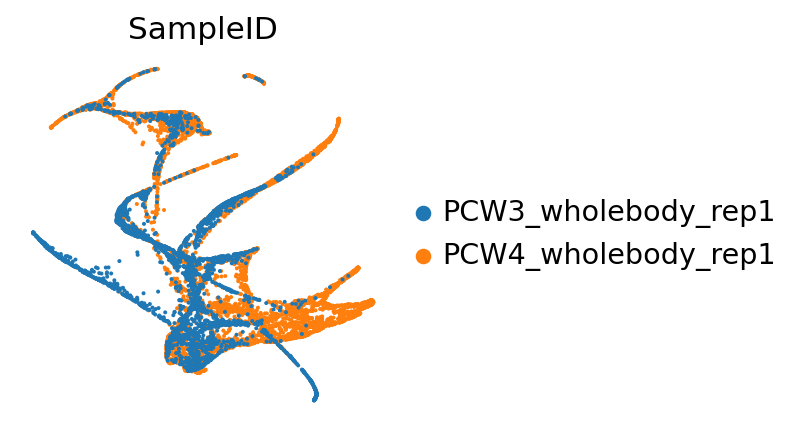

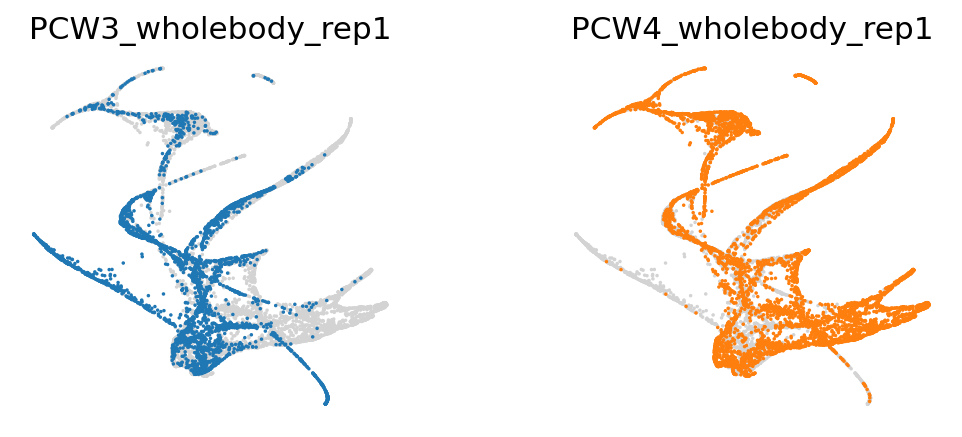

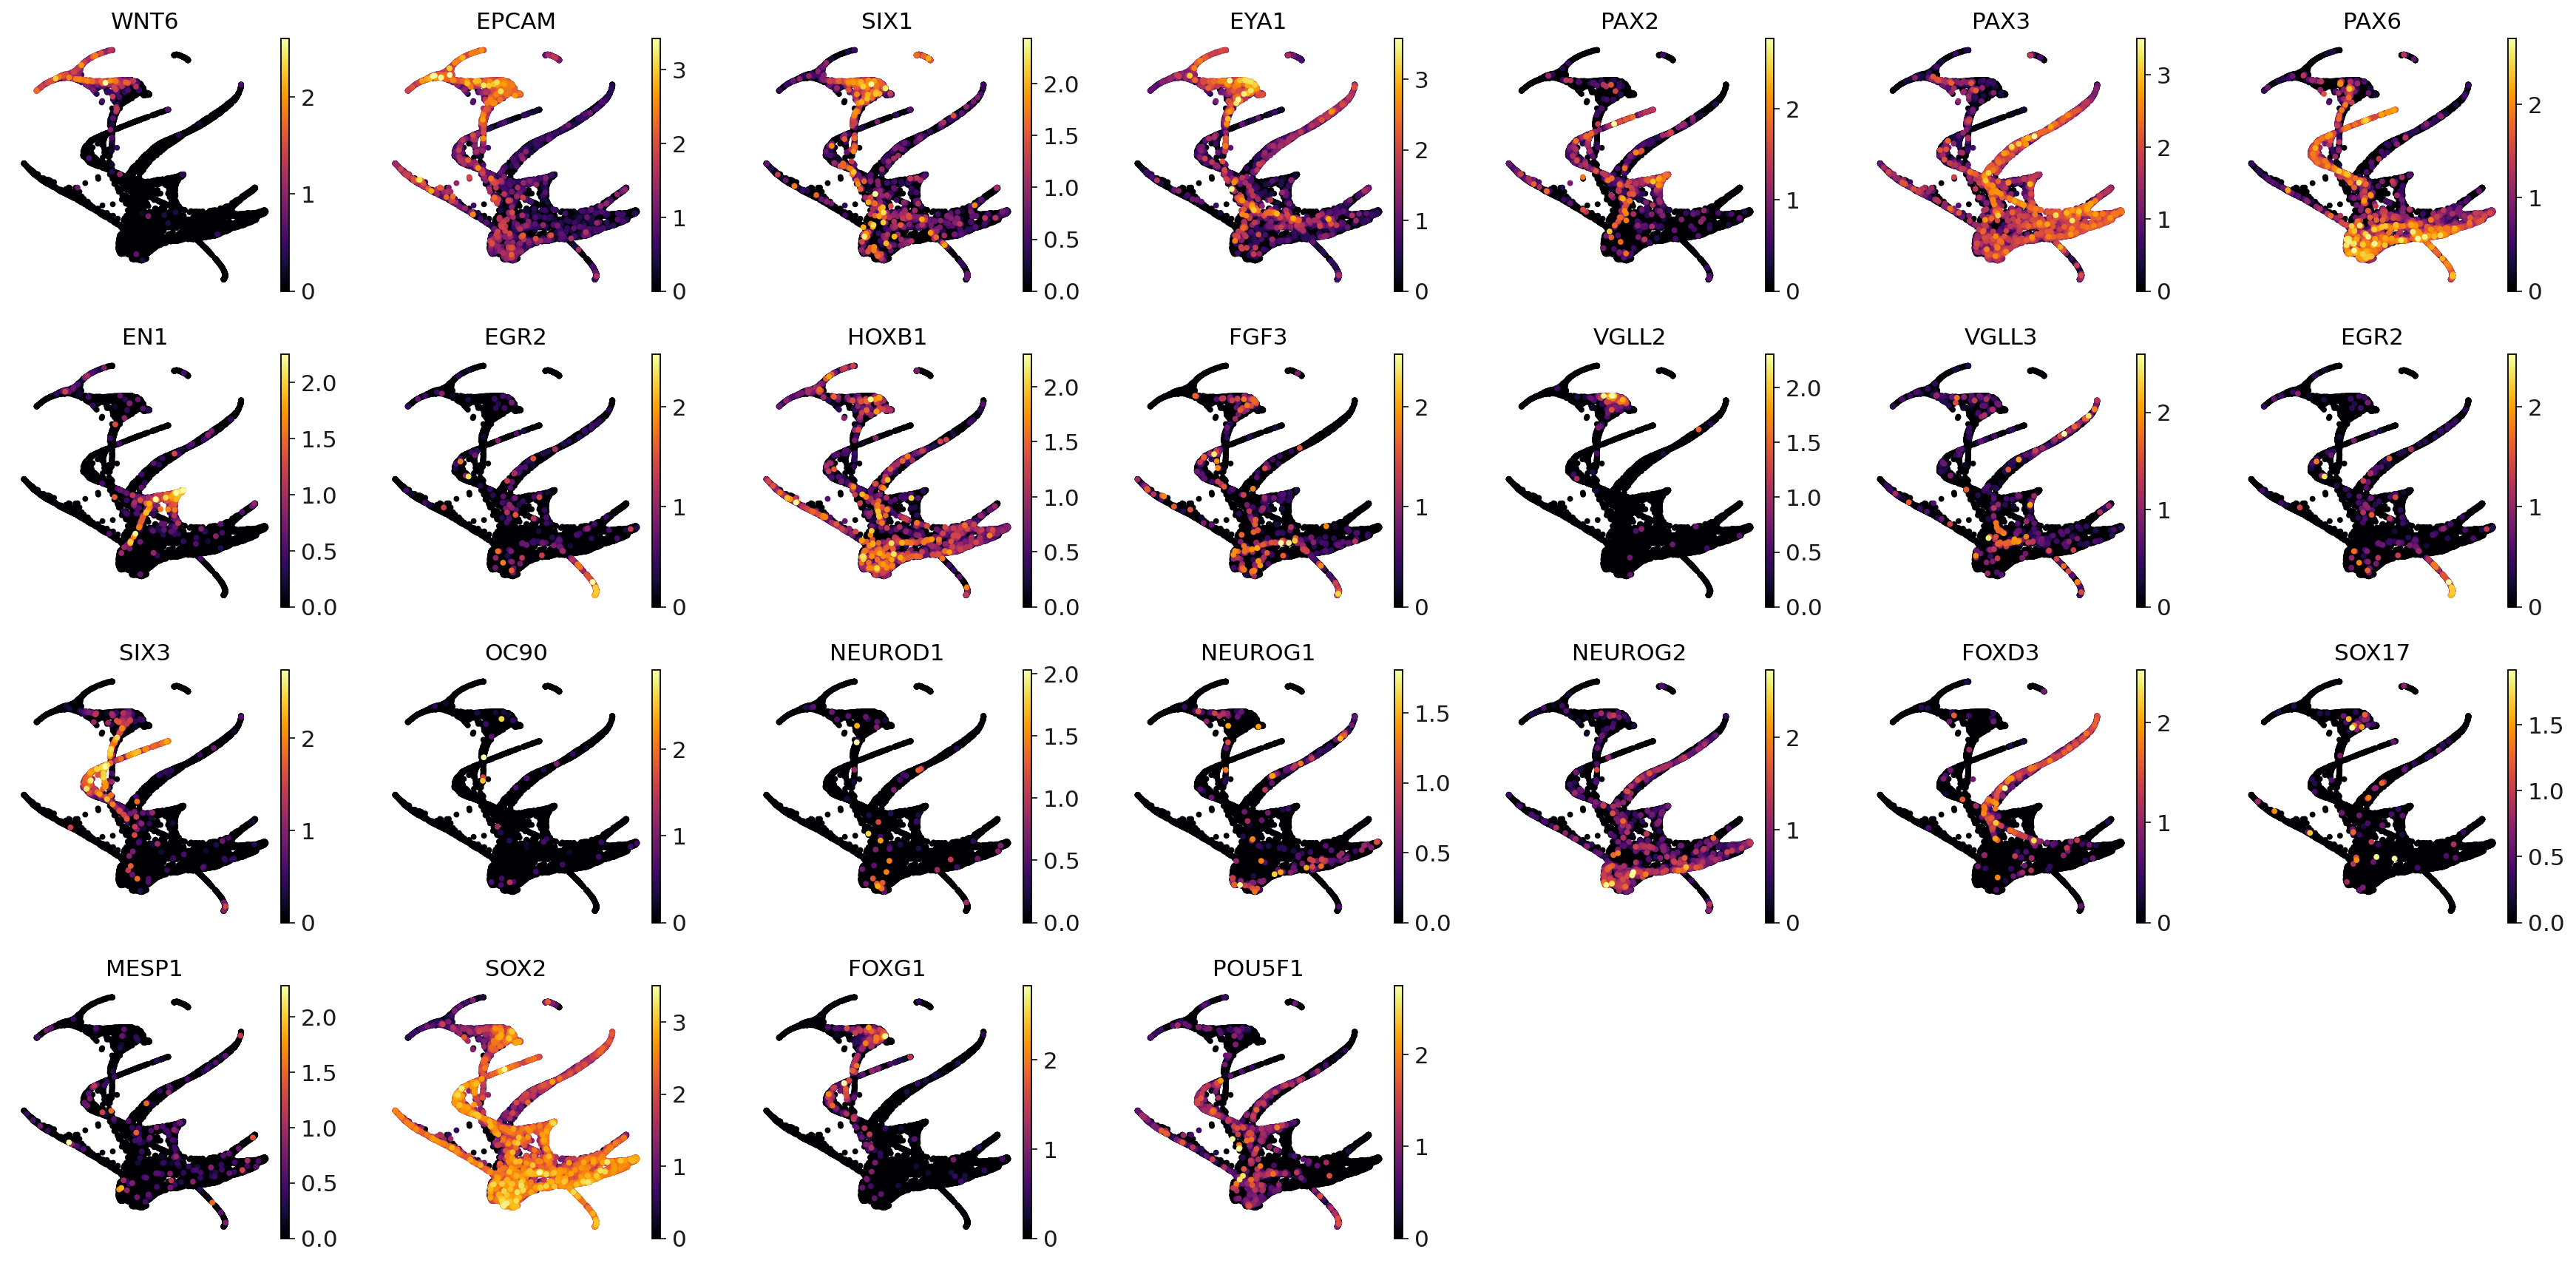

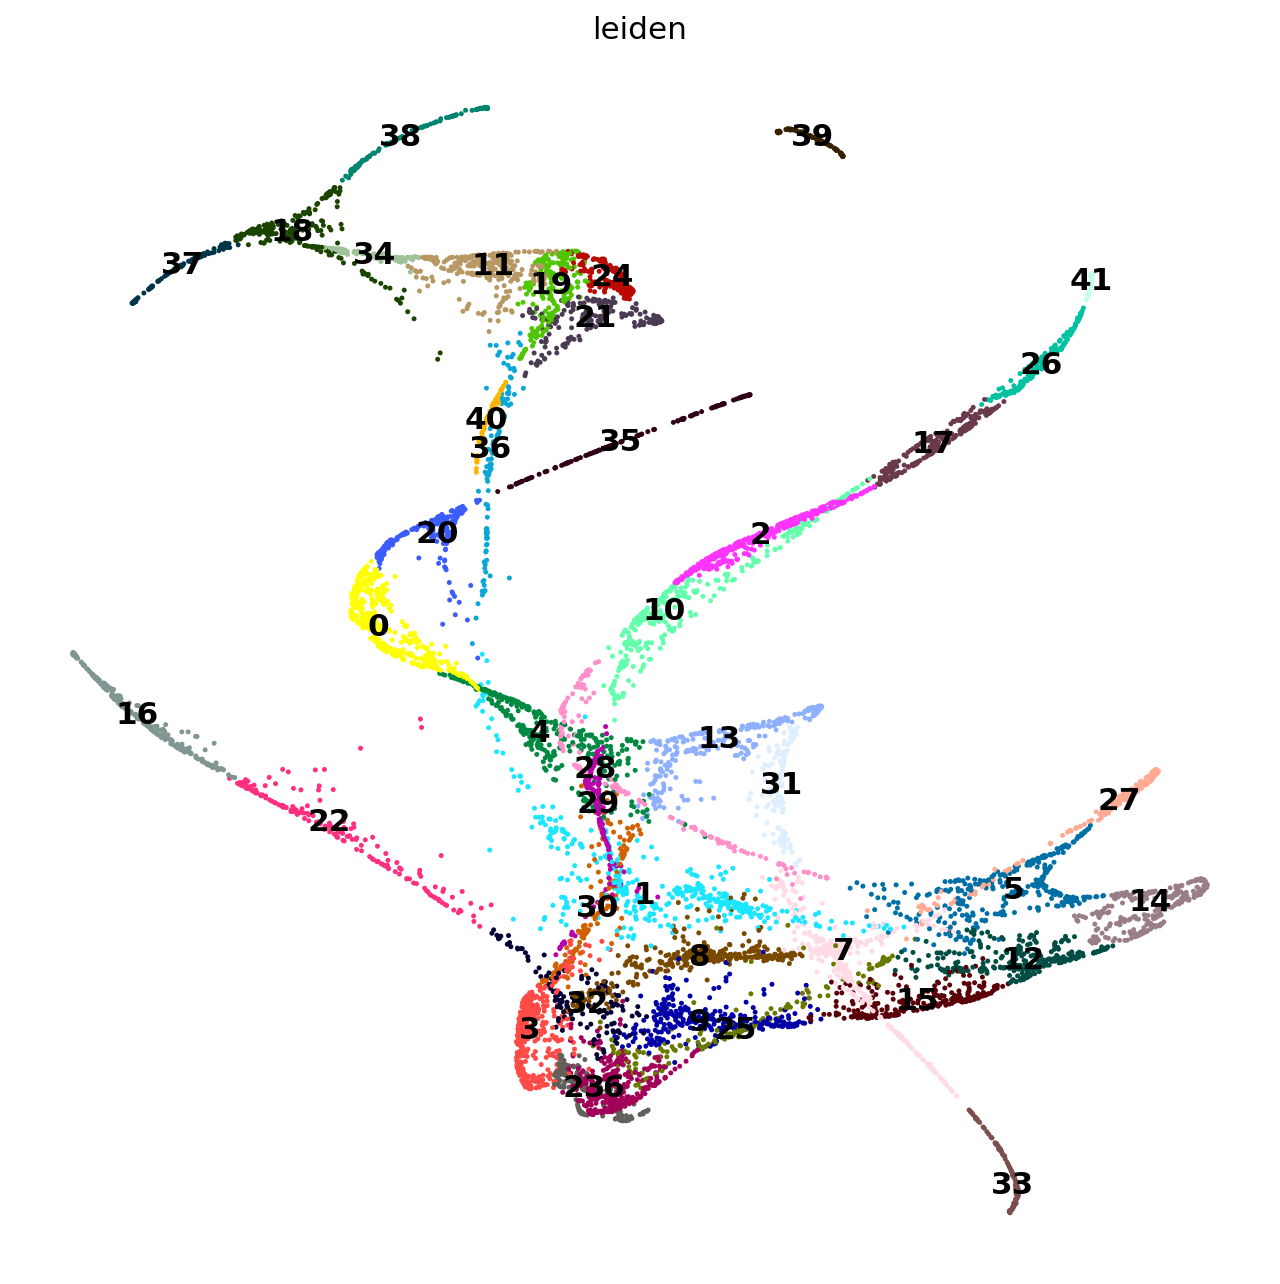

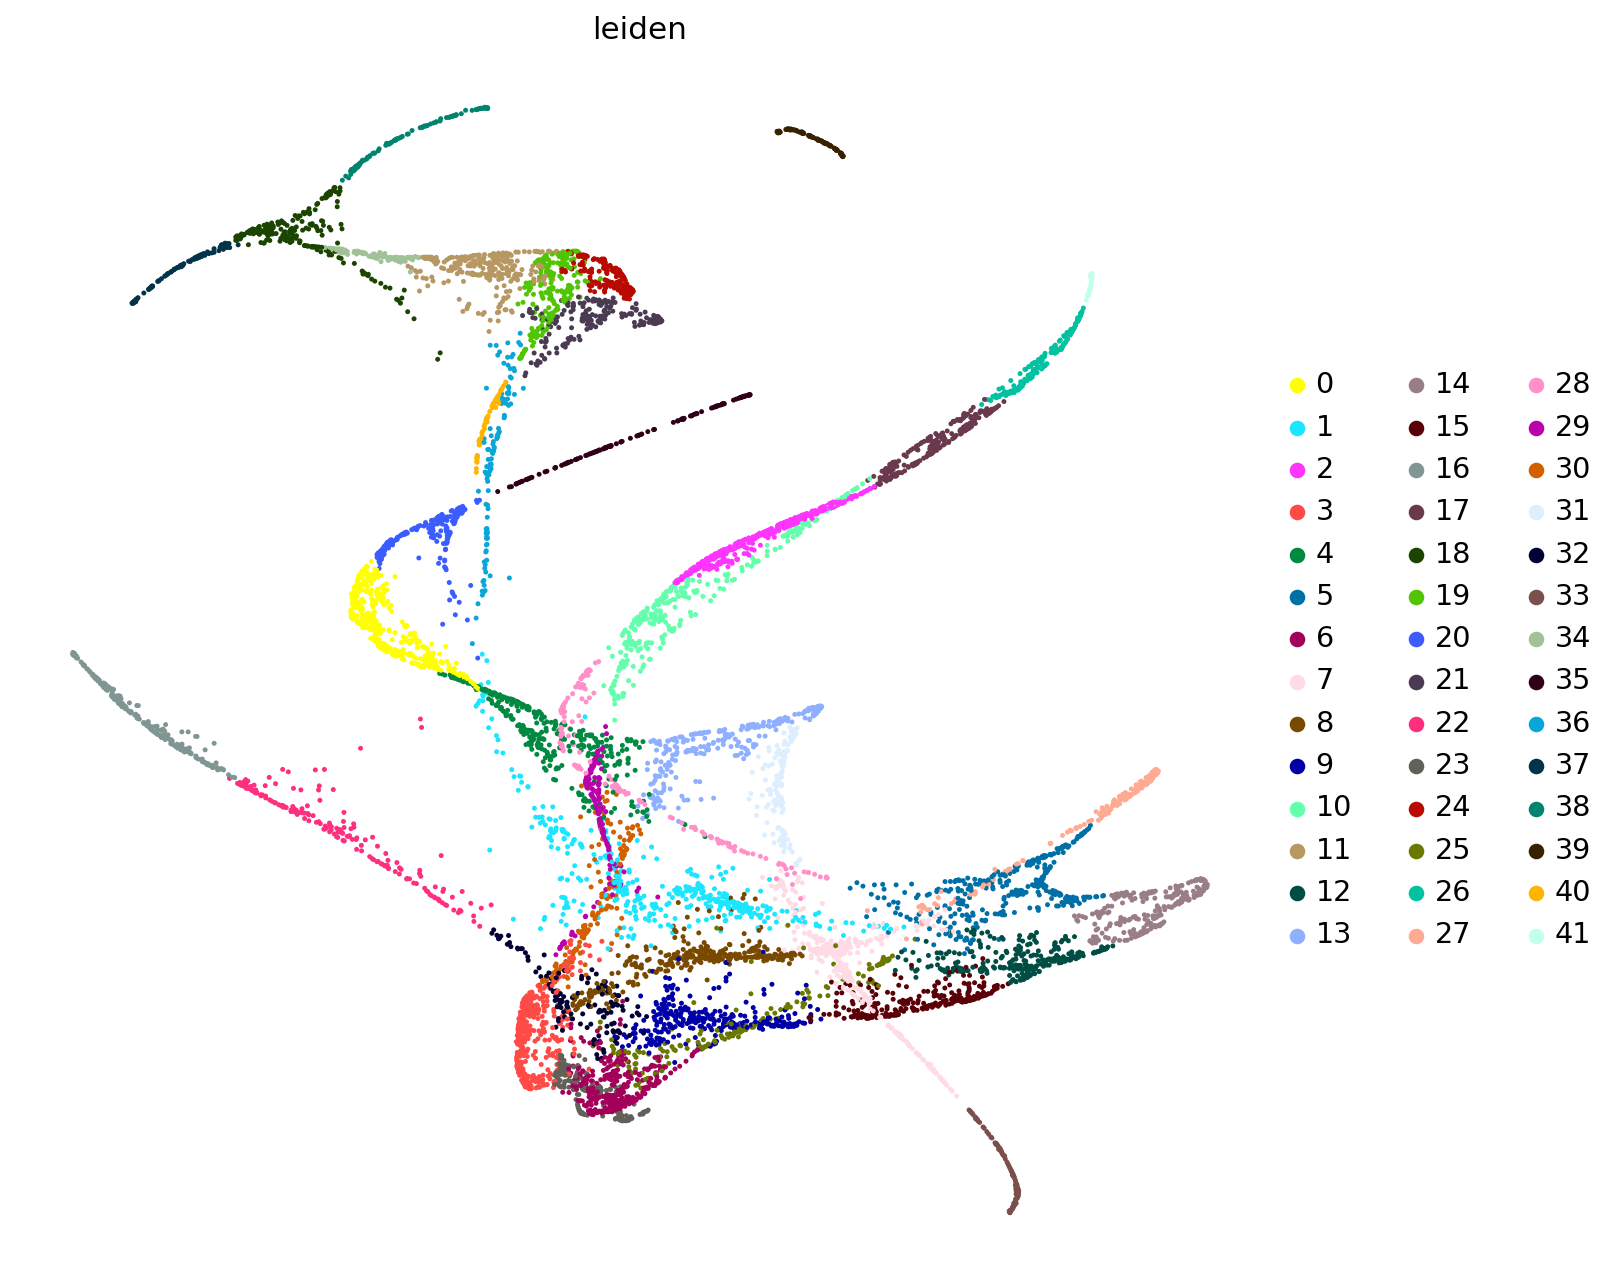

In [25]:
Placode1 = sc.read_h5ad(os.path.join(work_dir, 'scRNA/Drawedgraph_barcode_matching_scATAC_0610_1813.h5ad'))
#Placode2 = Placode1[Placode1.obs['celltype'].isin(['NPB', 'Placode_progenitor', 'Anterior_placode', 'Posterior_placode', 'Intermediate_placode', 'Epidermal'])]
#Placode3 = Placode2[~Placode2.obs['SampleID'].isin(['E950_tdT_rep1_Liu', 'E950_tdT_rep2_Liu', 'E1050_OV_rep1_Morrow', 'E950_mandibular_Jimmy', 'E925_lens_Kanai', 'E950_Liu', 'E1050_PA1_Robb', 'E1050_PA1_Sham', 'E1050_PA2_Robb', 'E1050_mandibular_Chai', 'E1050_mandibular_Jiang', 'E1150_facial_Zhou'])]
adata_totalplacode = sc.read_h5ad(os.path.join(work_dir, 'scRNA/All_Epi_combined_withvelo.h5ad'))
adata_totalplacode = adata_totalplacode[Placode1.obs.index, ]
adata_totalplacode.obsm = None
adata_totalplacode.var = adata_totalplacode.var[['MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'RPS', 'RPL']]


sc.pp.highly_variable_genes(adata_totalplacode, n_top_genes=4000, flavor='cell_ranger', batch_key="SampleID")
sc.pp.pca(adata_totalplacode, n_comps = 40)


#Prepare metadata and PCA
meta_data = adata_totalplacode.obs
data_mat = adata_totalplacode.obsm["X_pca"]
# Import and run harmony
import harmonypy as hm
ho = hm.run_harmony(data_mat, meta_data, "SampleID", max_iter_harmony = 30)
# Mapping back the result to the adata object
adata_totalplacode.obsm["X_pca"] = ho.Z_corr.T


# Build KNN and run UMAP
sc.pp.neighbors(adata_totalplacode, n_pcs =40)
sc.tl.umap(adata_totalplacode, min_dist = 0.1)
# Run clustering with leiden
sc.tl.leiden(adata_totalplacode, resolution=1)

pca_projections = pd.DataFrame(adata_totalplacode.obsm["X_pca"],index=adata_totalplacode.obs_names)
#adata.obs = adata.obs[['SampleID']]
#adata.var = adata.var[['highly_variable', 'means', 'dispersions', 'dispersions_norm']]
#Run Palantir to obtain multiscale diffusion space
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components = 40, knn = 30) #n_components default = 10; knn default = 30
ms_data = palantir.utils.determine_multiscale_space(dm_res) #If None specified, the number of eigen vectors will be determined using eigen gap

# generate neighbor draph in multiscale diffusion space
adata_totalplacode.obsm["X_palantir"]=ms_data.values
sc.pp.neighbors(adata_totalplacode,n_neighbors=15,use_rep="X_palantir")
# draw ForceAtlas2 embedding using 2 first PCs as initial positions
adata_totalplacode.obsm["X_pca2d"]=adata_totalplacode.obsm["X_pca"][:,:2]
sc.tl.draw_graph(adata_totalplacode,init_pos='X_pca2d')
sc.tl.leiden(adata_totalplacode, resolution=1)

sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')
sc.pl.draw_graph(adata_totalplacode, color='SampleID')
def cluster_small_multiples(adata, clust_key, size=10, frameon=False, legend_loc=None, **kwargs):
    tmp = adata.copy()

    for i,clust in enumerate(adata.obs[clust_key].cat.categories):
        tmp.obs[clust] = adata.obs[clust_key].isin([clust]).astype('category')
        tmp.uns[clust+'_colors'] = ['#d3d3d3', adata.uns[clust_key+'_colors'][i]]

    sc.pl.draw_graph(tmp, groups=tmp.obs[clust].cat.categories[1:].values, color=adata.obs[clust_key].cat.categories.tolist(), size=size, frameon=frameon, legend_loc=legend_loc, **kwargs)
    
cluster_small_multiples(adata_totalplacode, 'SampleID', ncols = 7)

sc.pl.draw_graph(adata_totalplacode,color=['WNT6', 'EPCAM', 'SIX1', 'EYA1', 'PAX2', 'PAX3', 'PAX6', 'EN1', 'EGR2', 'HOXB1', 'FGF3', 'VGLL2', 'VGLL3', 'EGR2', 'SIX3',
                                           'OC90', 'NEUROD1', 'NEUROG1', 'NEUROG2', 'FOXD3', 'SOX17', 'MESP1', 'SOX2', 'FOXG1', 'POU5F1'], ncols = 7, size = 50, color_map='inferno')

sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(10, 10), facecolor='white')
sc.pl.draw_graph(adata_totalplacode,color=['leiden'], ncols = 7, vmin = 0.5, size = 20, legend_loc = 'on data')
sc.pl.draw_graph(adata_totalplacode,color=['leiden'], ncols = 7, vmin = 0.5, size = 20)

sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')
#adata_totalplacode.write(os.path.join(work_dir, 'scRNA/20230312_ectoderm_19comp_20neighbors_drawedgraph.h5ad'), compression='gzip')

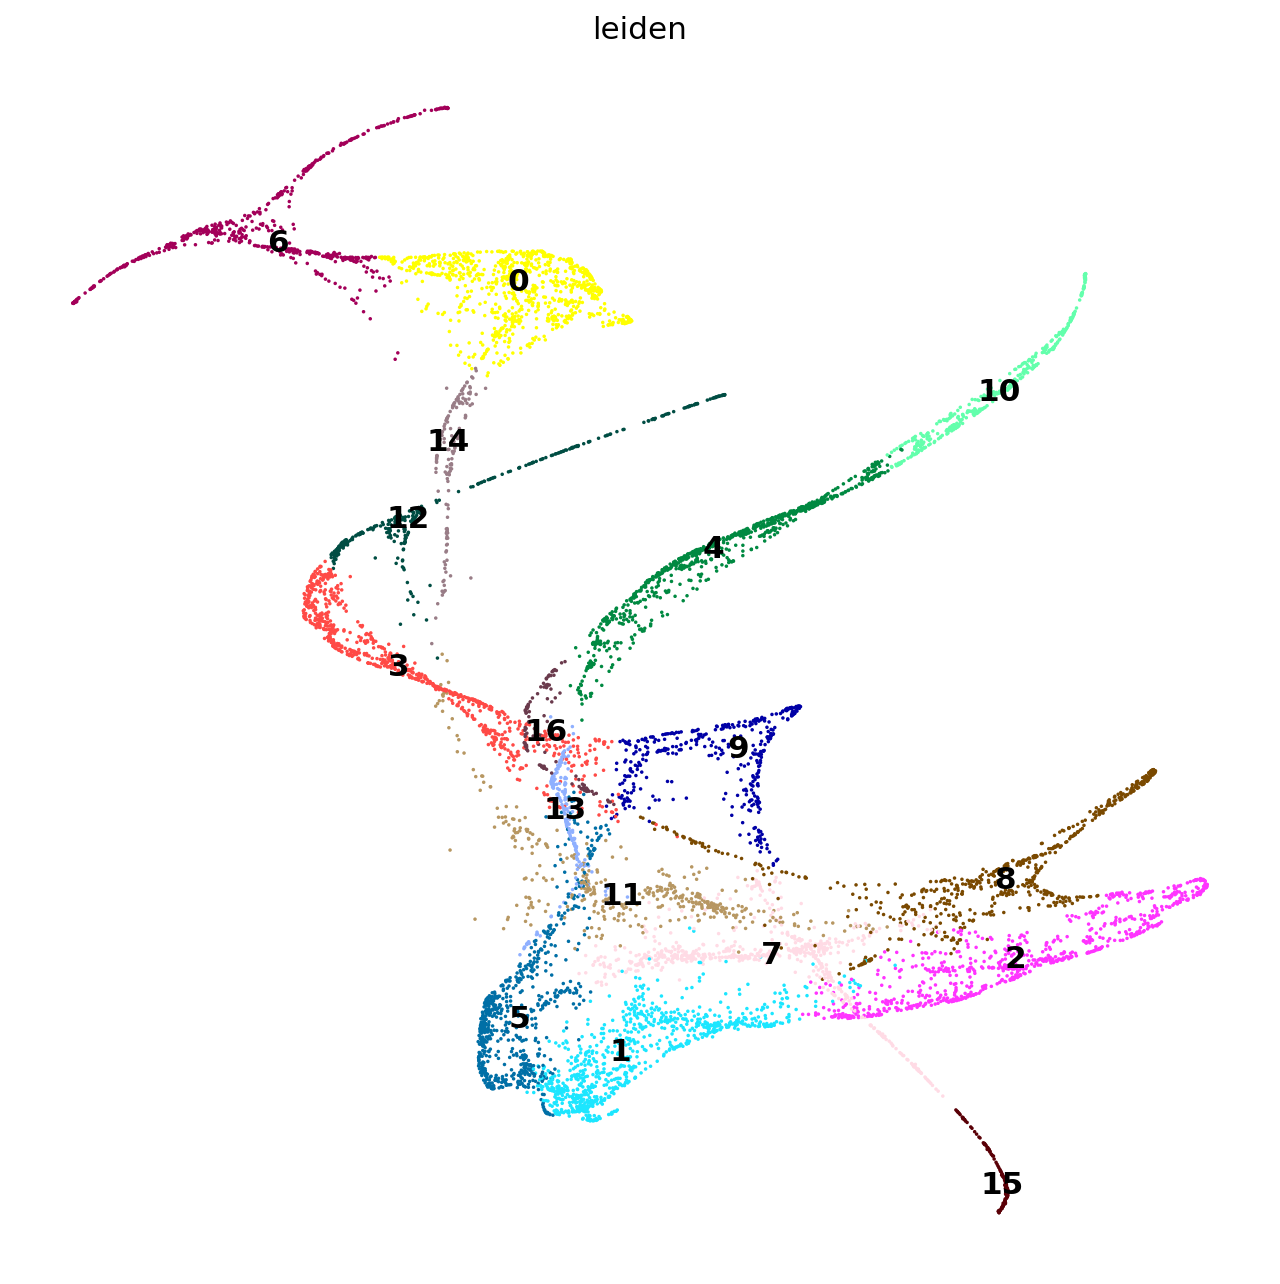

In [36]:
cleaned = adata_totalplacode[~adata_totalplacode.obs['leiden'].isin(['39', '16', '22', '32'])]

sc.tl.leiden(cleaned, resolution = 0.2)
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(10, 10), facecolor='white')
sc.pl.draw_graph(cleaned,color=['leiden'], ncols = 7, vmin=1, vmax = 5, size = 10, legend_loc = 'on data')

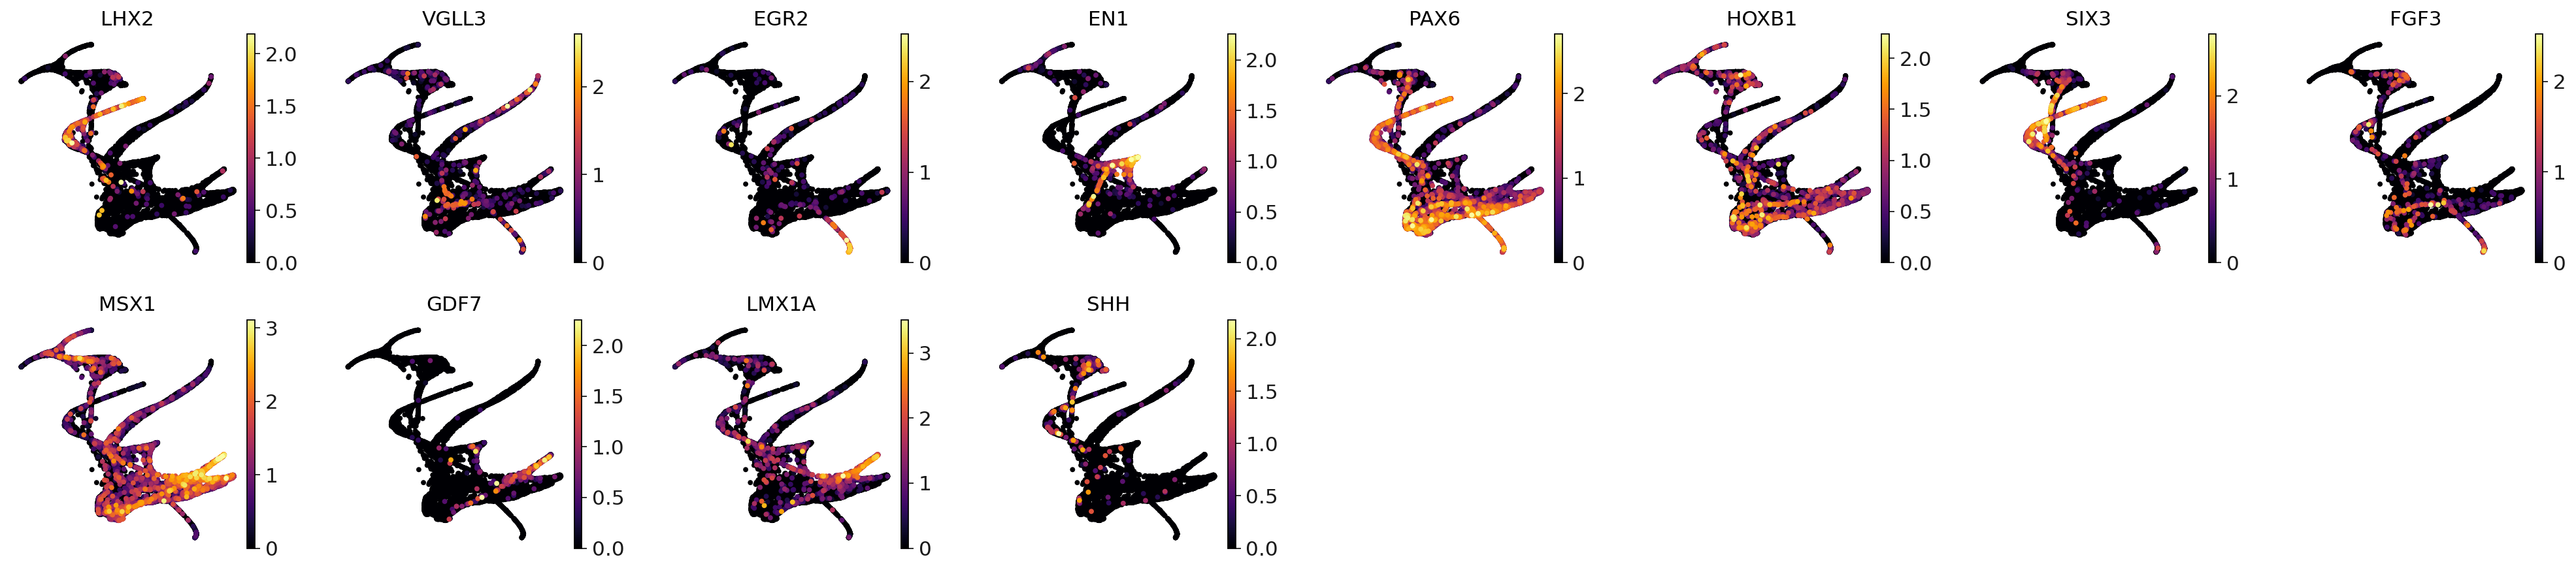

In [55]:
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')
sc.pl.draw_graph(cleaned,color=['LHX2', 'VGLL3', 'EGR2', 'EN1', 'PAX6', 'HOXB1', 'SIX3', 'FGF3', 'MSX1', 'GDF7', 'LMX1A', 'SHH'], ncols = 8, size = 50, color_map='inferno')
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(10, 10), facecolor='white')

In [32]:
cleaned.write(os.path.join(work_dir, 'scRNA/Step1f_cleaned.h5ad'), compression='gzip')

In [58]:
tmp_df = cleaned.obs.groupby(['leiden', 'leiden']).size().unstack(fill_value=0)
tmp_df = (tmp_df / tmp_df.sum(0)).fillna(0)
leiden_to_annotation = tmp_df.idxmax(1).to_dict()
leiden_to_annotation['0'] = '04_Placode'
leiden_to_annotation['1'] = '01_Epiblast'
leiden_to_annotation['2'] = '08_Diencephalon'
leiden_to_annotation['3'] = '07_Telencephalon'
leiden_to_annotation['4'] = '05_Neural_crest'
leiden_to_annotation['5'] = '01_Epiblast'
leiden_to_annotation['6'] = '03_Epidermal'
leiden_to_annotation['7'] = '06_Neuroectoderm'
leiden_to_annotation['8'] = '11_Roof_plate'
leiden_to_annotation['9'] = '09_Mesencephalon'
leiden_to_annotation['10'] = '05_Neural_crest'
leiden_to_annotation['11'] = '02_Non_neuroectoderm'
leiden_to_annotation['12'] = '07_Telencephalon'
leiden_to_annotation['13'] = '05_Neural_crest'
leiden_to_annotation['14'] = '04_Placode'
leiden_to_annotation['15'] = '10_Rhombomere'
leiden_to_annotation['16'] = '05_Neural_crest'


leiden_to_annotation = {cluster: leiden_to_annotation[cluster].replace(' ', '_') for cluster in leiden_to_annotation.keys()}

In [59]:
cleaned.obs['celltype'] = [leiden_to_annotation[cluster_id] for cluster_id in cleaned.obs['leiden']]
del(leiden_to_annotation)
del(tmp_df)

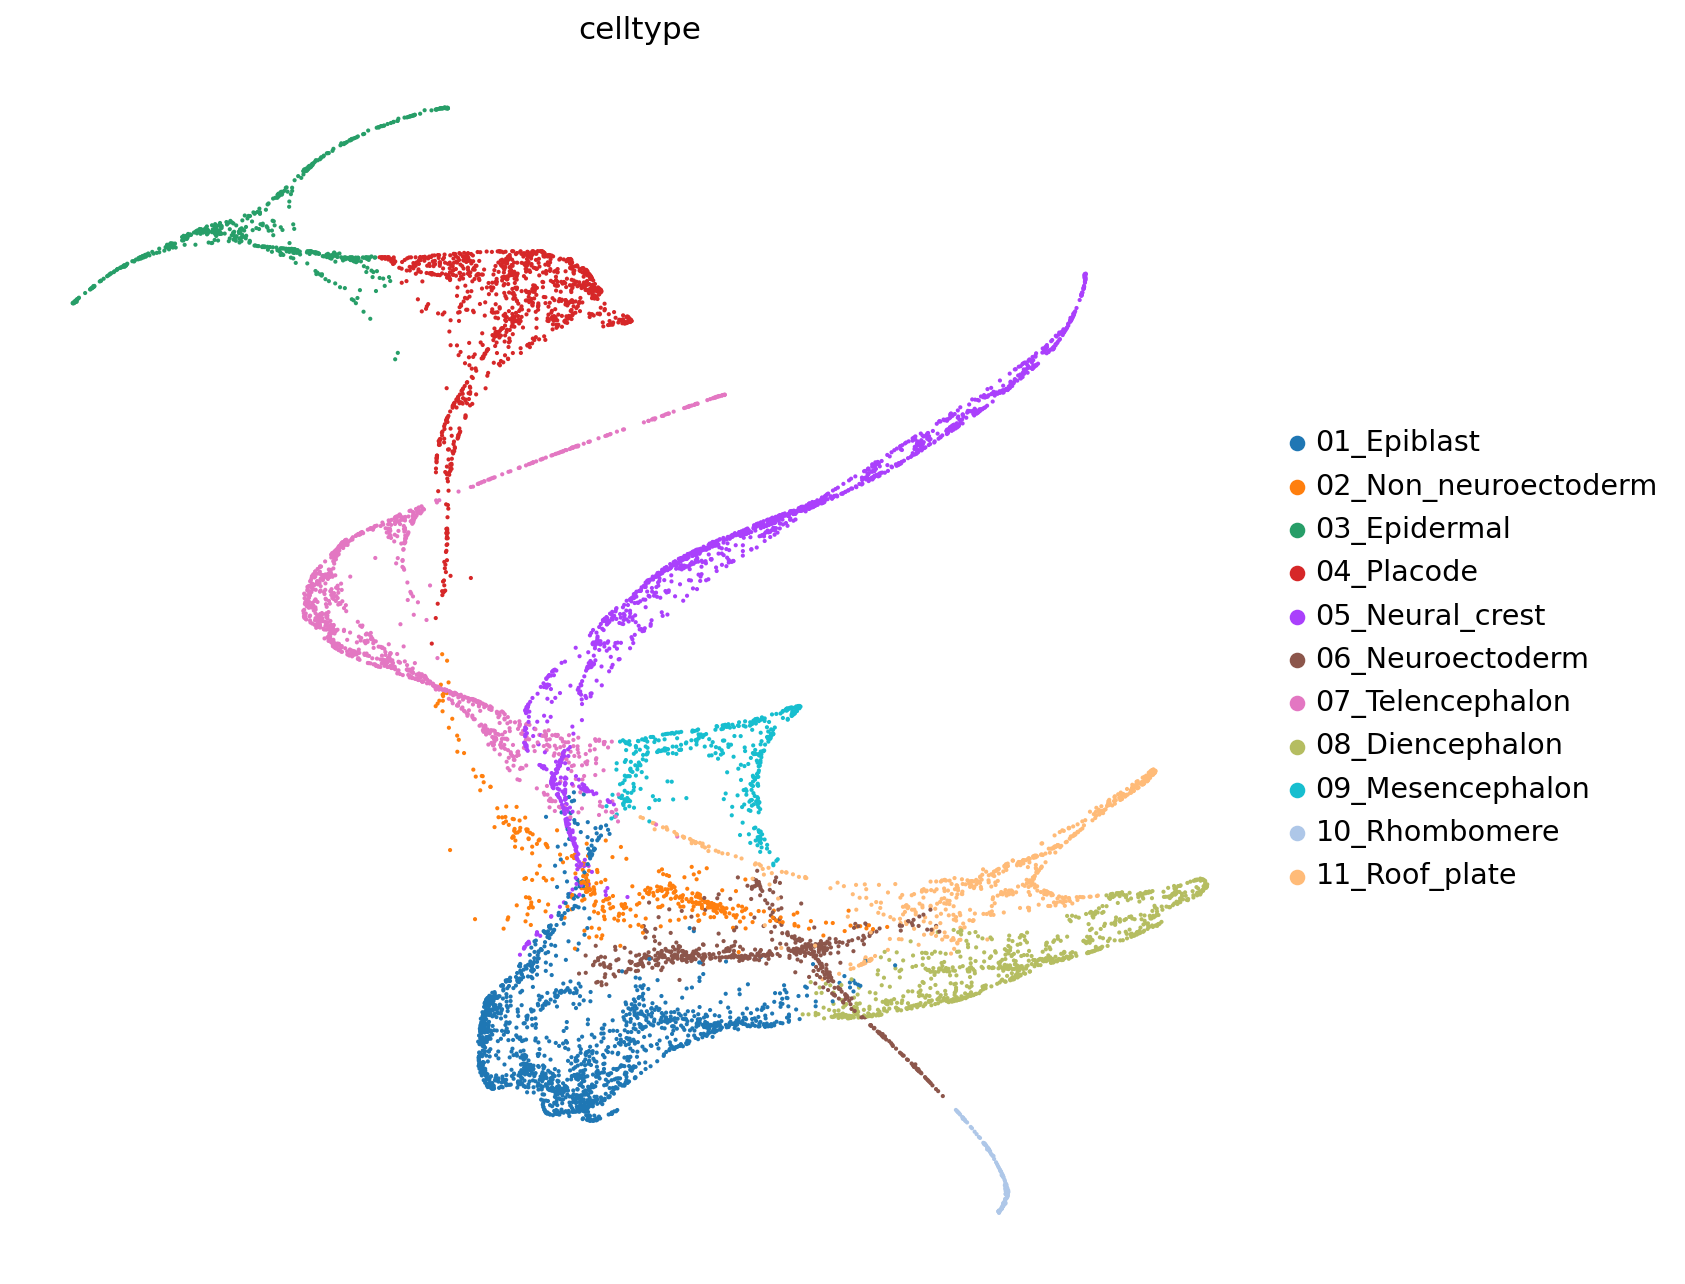

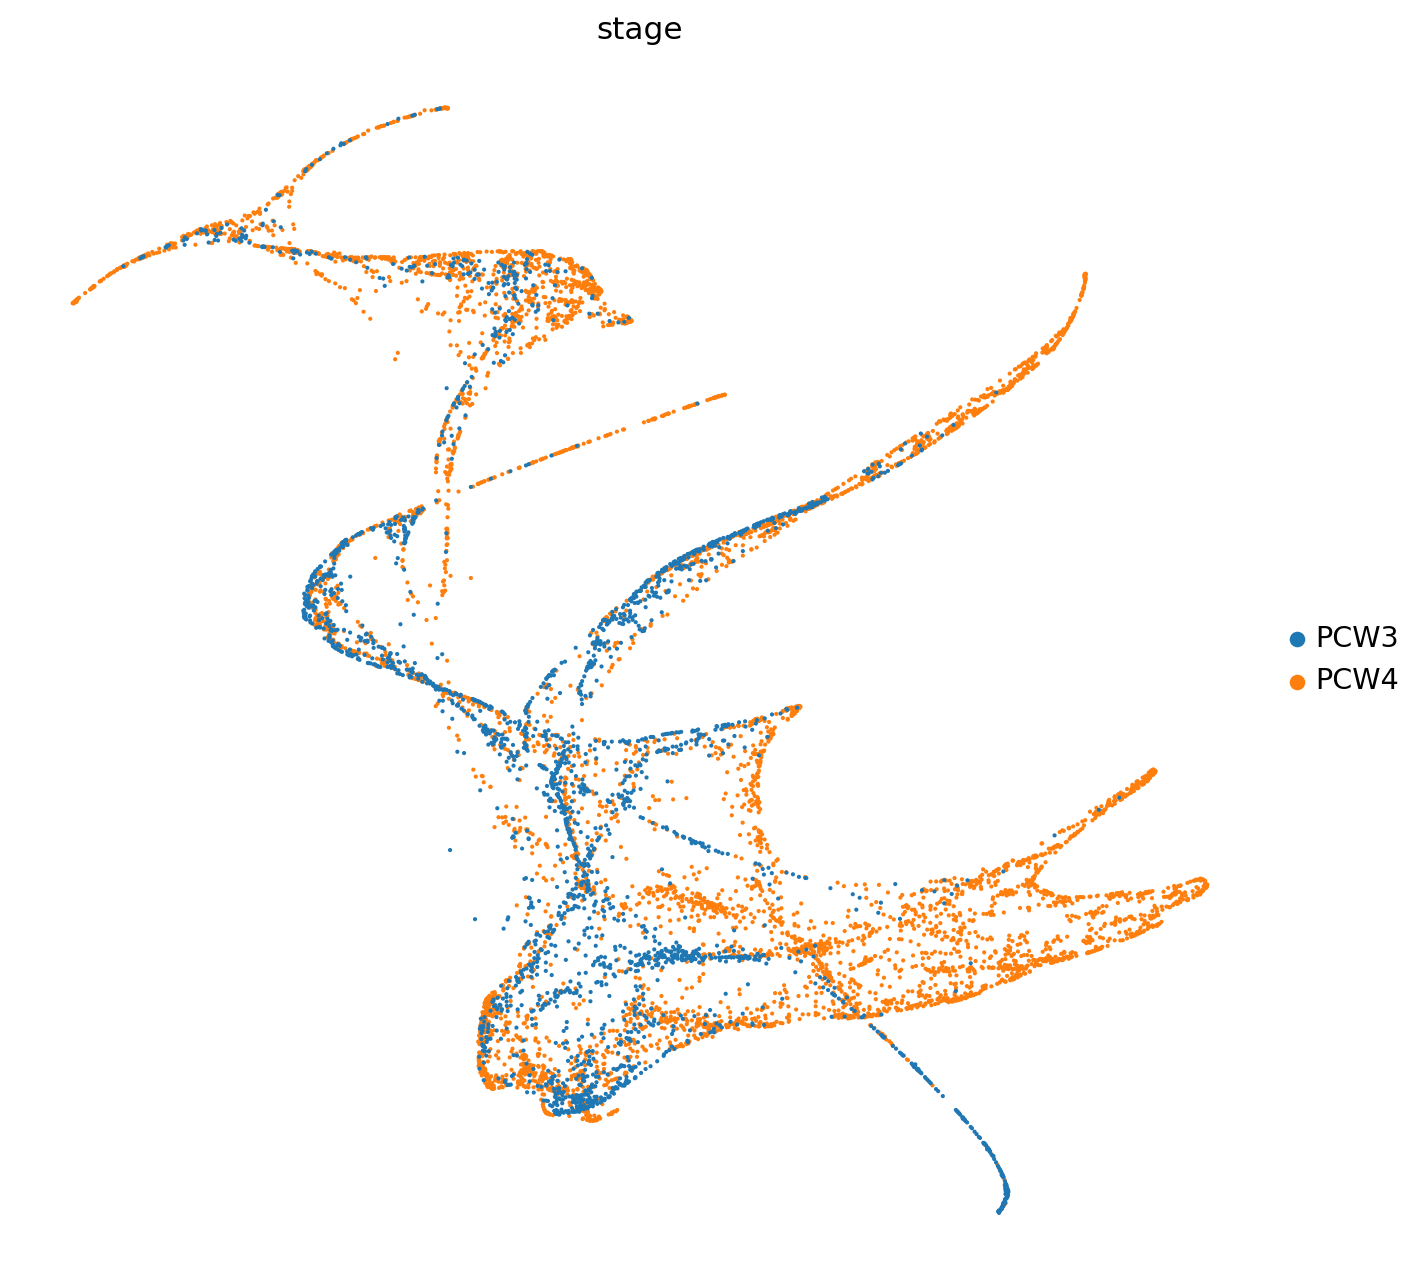

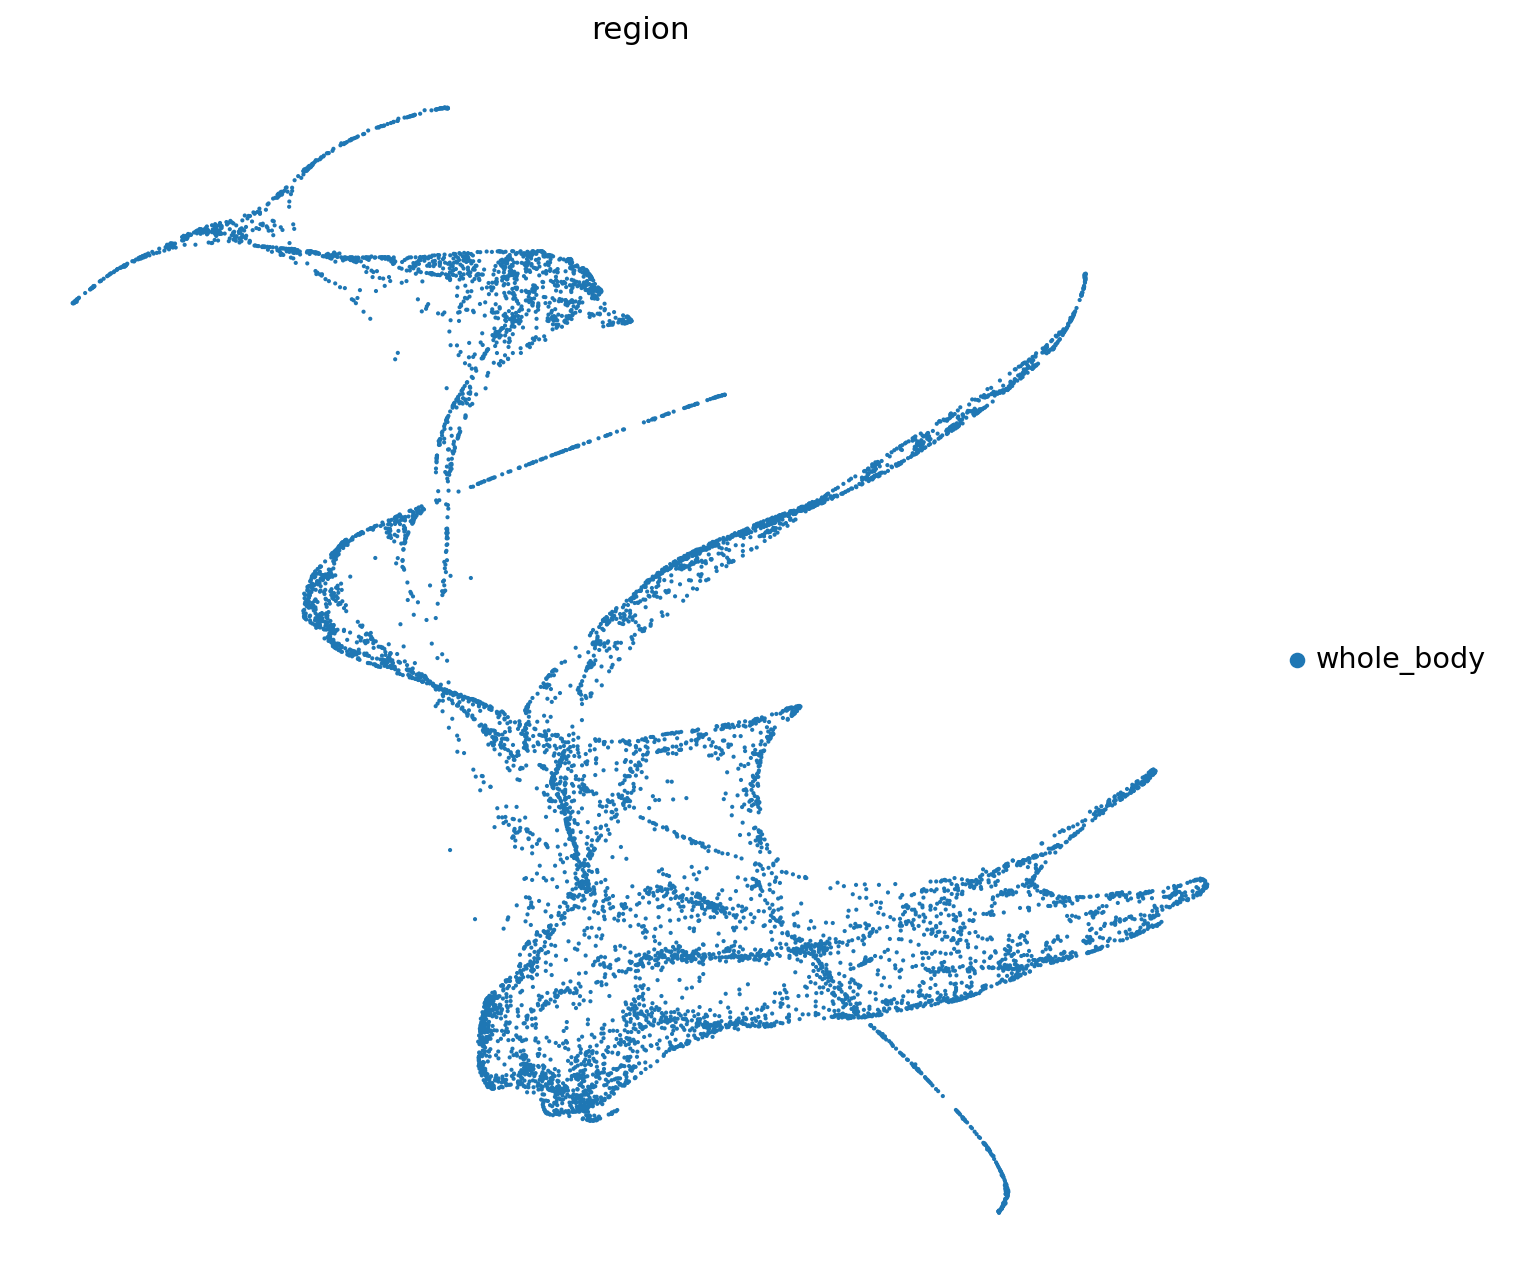

AnnData object with n_obs × n_vars = 8575 × 8108
    obs: 'stage', 'SampleID', 'region', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'total_counts_RPS', 'pct_counts_RPS', 'total_counts_RPL', 'pct_counts_RPL', 'doublet_score', 'predicted_doublet', 'leiden', 'celltype'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'RPS', 'RPL', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'draw_graph', 'SampleID_colors', 'leiden_colors', 'celltype_colors', 'stage_colors', 'region_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'X_palantir', 'X_pca2d', 'X_draw_graph_fa'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [60]:
sc.pl.draw_graph(cleaned, color = ['celltype'])
sc.pl.draw_graph(cleaned, color = ['stage'])
sc.pl.draw_graph(cleaned, color = ['region'])
cleaned

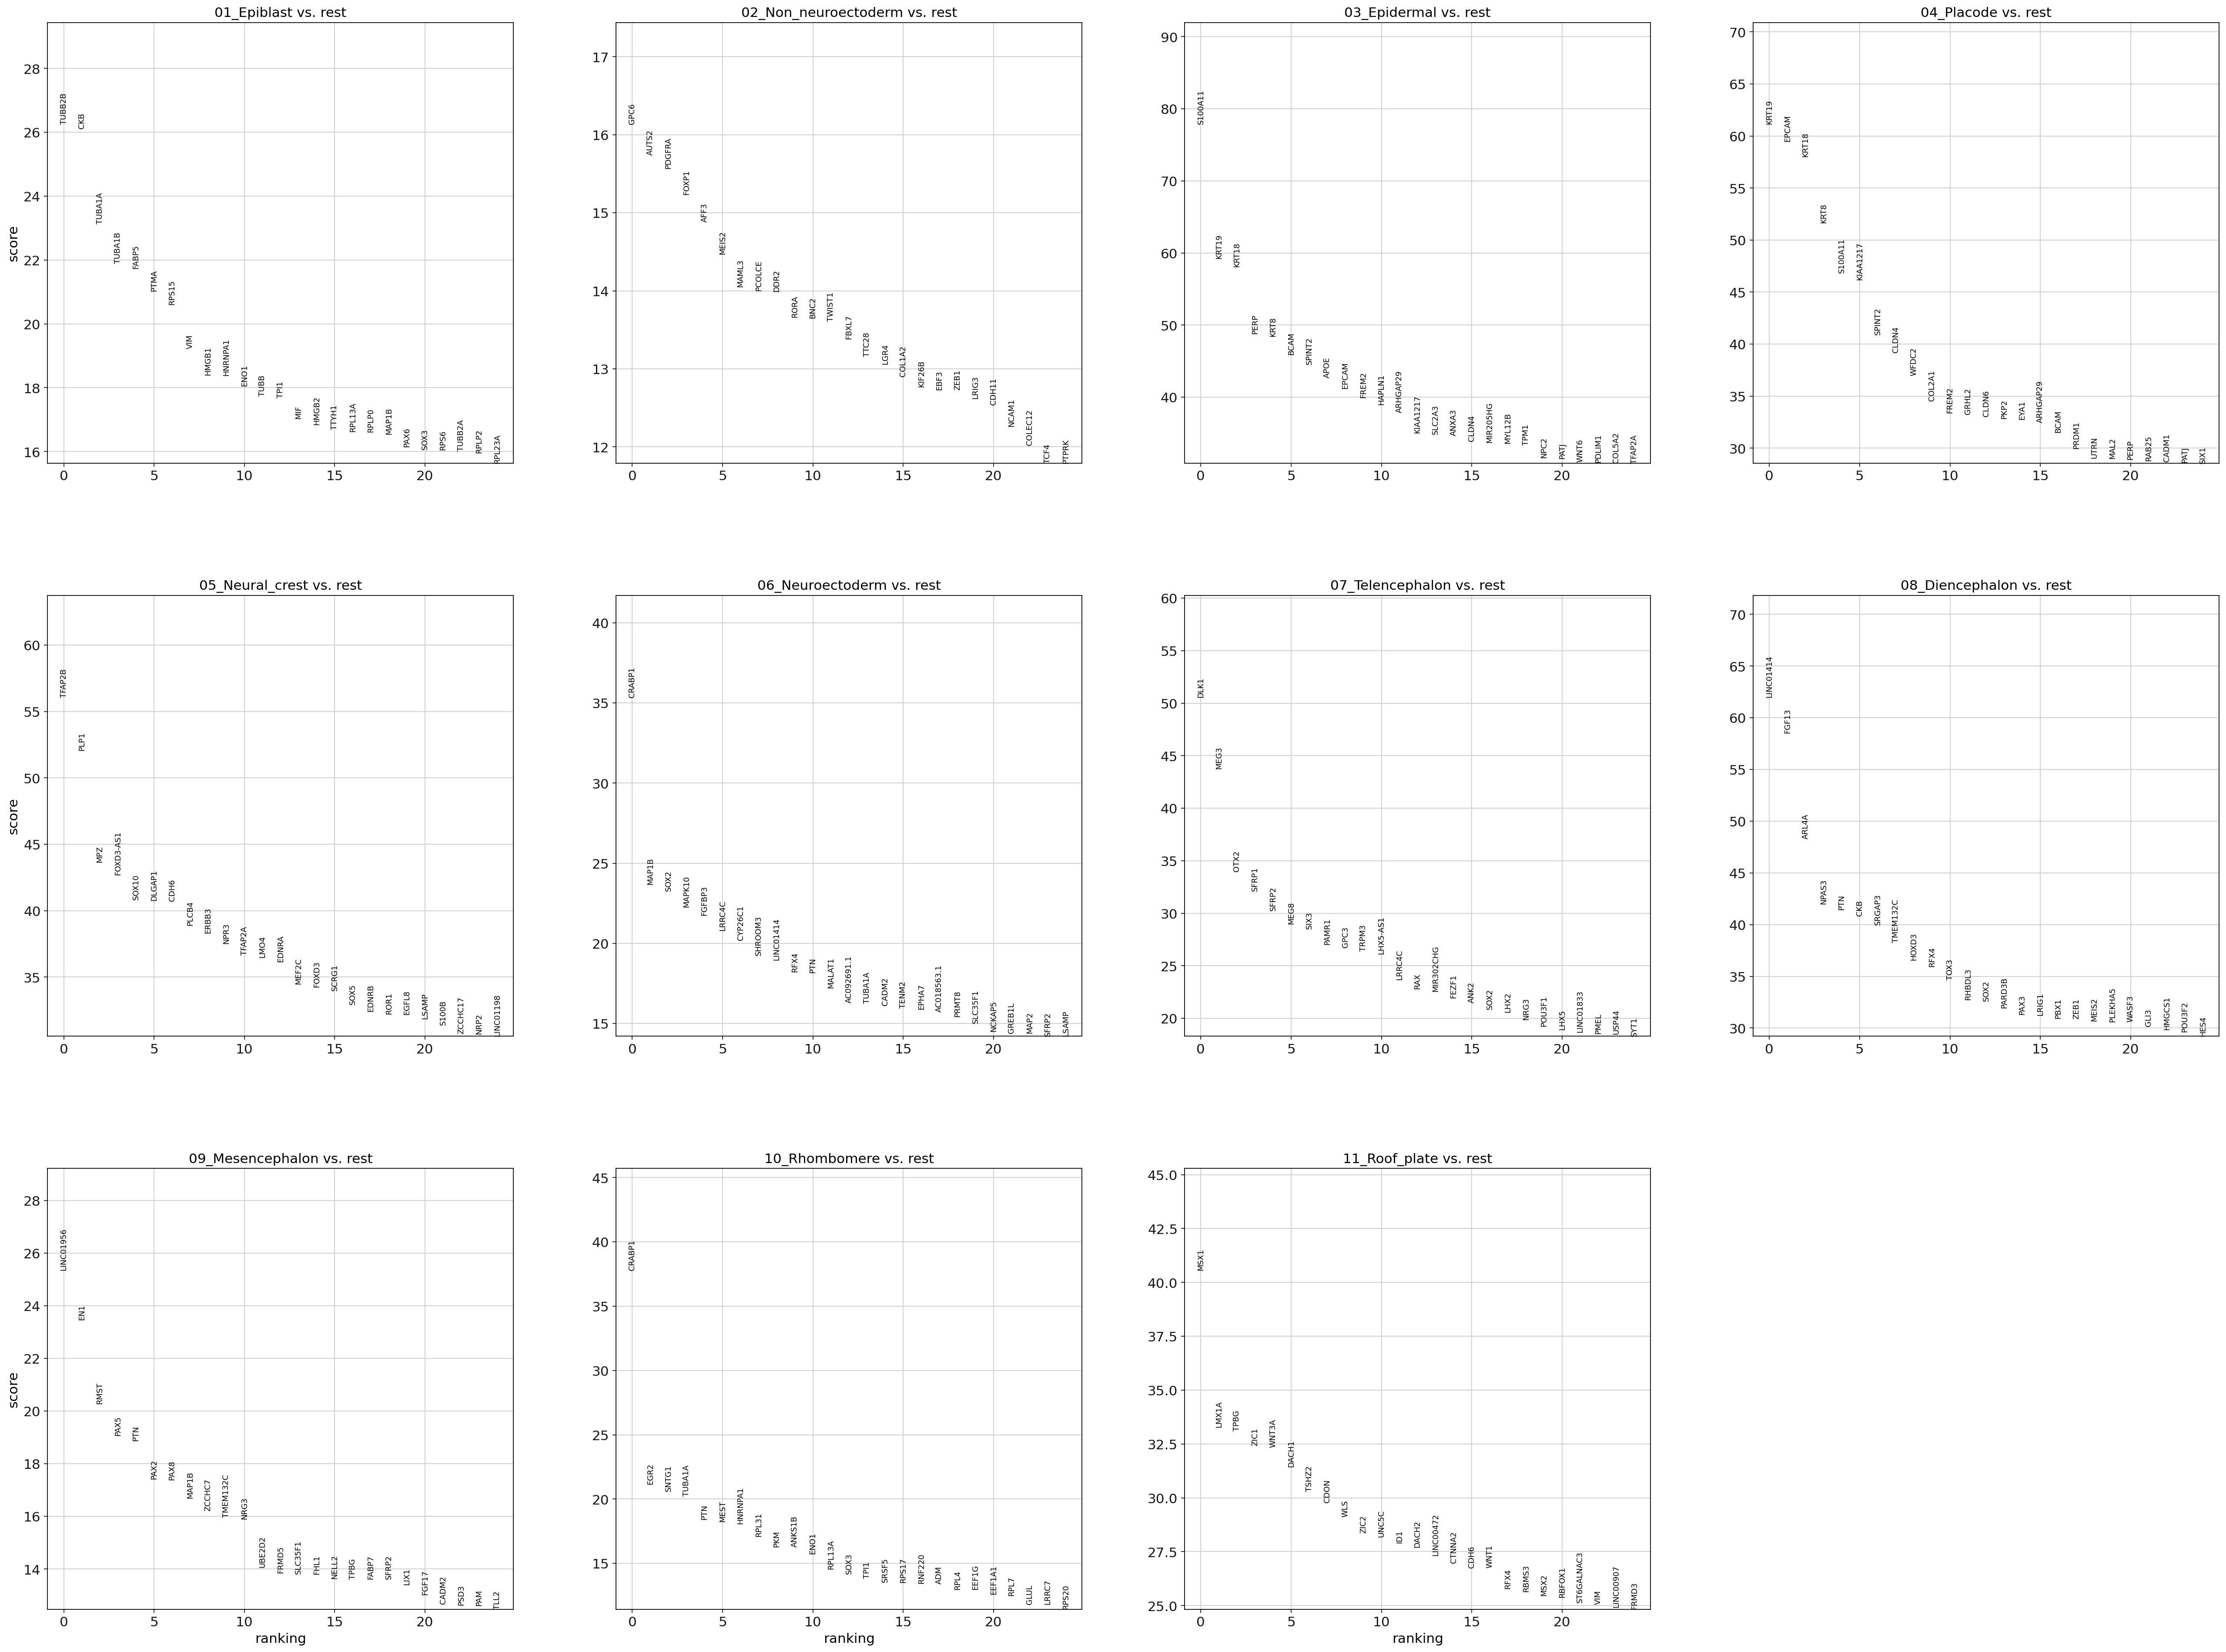

In [61]:
sc.tl.rank_genes_groups(cleaned, 'celltype', method='t-test')
sc.pl.rank_genes_groups(cleaned, n_genes=25, sharey=False)

In [62]:
cleaned.write(os.path.join(work_dir, 'scRNA/Step1f_cleaned_annotated.h5ad'), compression='gzip')